# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# Import other modules if required
# Can use other libraries as well
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from glob import glob
import os,sys
from PIL import Image

resnet_input = 225 #size of resnet18 input images

In [2]:
# Choose your hyper-parameters using validation data
batch_size = 64
num_epochs = 5
learning_rate =  0.005
hyp_momentum = 0.9

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [3]:
classes = ('__background__',
           'aeroplane',
           'bottle','chair'
           )
back_classes =  ('bicycle','bird', 'boat', 'bus',
                 'car', 'cat', 'cow', 'diningtable', 'dog', 'horse',
                 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

In [4]:
# def build_dataset():
#     # Begin

In [5]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        self.train = train
        self.transforms = transform
        self.data = []
        self.objects = []
        count_pclass = [0 for i in range(17)]
        
        if(train==True):
            with open(root_dir + "VOC2007/ImageSets/Main/trainval.txt") as f:
                for l in f:
                    self.data.append(l.split())
        else:
            with open(root_dir + "VOC2007/ImageSets/Main/test.txt") as f:
                for l in f:
                    self.data.append(l.split())
        
        for f in self.data:
            tree = ET.parse( root_dir + "VOC2007/Annotations/" + f[0] + ".xml")
            filename = tree.find('filename').text
            for obj in tree.findall('object'):
                obj_struct = {}
                if(obj.find('name').text in classes):
                    obj_struct['img_name'] = filename
                    obj_struct['class'] = classes.index(obj.find('name').text)
                    bbox = obj.find('bndbox')
                    obj_struct['bbox'] = [int(bbox.find('xmin').text),
                                          int(bbox.find('ymin').text),
                                          int(bbox.find('xmax').text),
                                          int(bbox.find('ymax').text)]
                    self.objects.append(obj_struct)
                
                
                if(obj.find('name').text in back_classes):
                    if(count_pclass[back_classes.index(obj.find('name').text)] < 100):
                        obj_struct['img_name'] = filename
                        obj_struct['class'] = 0
                        count_pclass[back_classes.index(obj.find('name').text)]  +=1 
                        bbox = obj.find('bndbox')
                        obj_struct['bbox'] = [int(bbox.find('xmin').text),
                                              int(bbox.find('ymin').text),
                                              int(bbox.find('xmax').text),
                                              int(bbox.find('ymax').text)]
                        self.objects.append(obj_struct)
                
        
        
    def __len__(self):
        return len(self.objects)
        
    def __getitem__(self, idx):
        f_name = self.objects[idx]['img_name']
        clss = self.objects[idx]['class']
        if (self.train == True) :
            image = Image.open('Datasets/Train_VOCdevkit/VOC2007/JPEGImages/' + f_name)
        else:
            image = Image.open('Datasets/Test_VOCdevkit/VOC2007/JPEGImages/' + f_name)
        boundary_box = self. objects[idx]['bbox']
        area = (boundary_box[0], boundary_box[1], boundary_box[2], boundary_box[3])
        cr_image = image
        if self.transforms is not None:
            cr_image = image.crop(area)
            cr_image = self.transforms(cr_image)
        return cr_image, clss
            

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [6]:
# composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
#                                          transforms.ToTensor(),
#                                          transforms.RandomHorizontalFlip()])
transformations = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# train_dataset = voc_dataset(root_dir='Datasets/Train_VOCdevkit/', train=True, transform=transformations) # Supply proper root_dir
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Fine-tuning
### Use the pre-trained network to fine-tune the network in the following section:



In [7]:
# device = torch.device("cuda" if torch.cuda.is_available() 
#                                   else "cpu")
# model = models.resnet18(pretrained=True)
# # for param in model.parameters():
# #     param.requires_grad = False
# model.fc = nn.Linear(model.fc.in_features, 4)

In [8]:
# criterion = nn.CrossEntropyLoss()
# # Update if any errors occur
# optimizer = optim.SGD(model.parameters(), learning_rate, hyp_momentum)


In [9]:
# #One Layer Detection
# def train(curr_epoch):
#     model.train()
#     running_loss = 0
#     running_corrects = 0
# #     steps =0
#     for inputs, labels in train_loader:
# #         print(type(inputs), labels)
# #         steps += 1
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         logps = model.forward(inputs)
        
#         top_p, top_class = logps.topk(1, dim=1)
#         equals = top_class == labels.view(*top_class.shape)
        
#         loss = criterion(logps, labels)
#         running_loss += loss.item()
#         loss.backward()
#         optimizer.step()
        
    
#         running_corrects += torch.mean(equals.type(torch.FloatTensor)).item()

        
#     train_epoch_loss = running_loss/len(train_loader)
#     train_acc = running_corrects /len(train_loader)
    
#     test_loss = 0
#     test_accuracy = 0
#     model.eval()
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = nputs.to(device),labels.to(device)
#             logps = model.forward(inputs)
#             batch_loss = criterion(logps, labels)
#             test_loss += batch_loss.item()

#             ps = torch.exp(logps)
#             top_p, top_class = ps.topk(1, dim=1)
#             equals = top_class == labels.view(*top_class.shape)
#             test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
#     test_epoch_loss = test_loss/len(test_loader)
#     test_acc = test_accuracy/len(test_loader)

#     print('{} Train_Loss: {:.4f} Train_Acc: {:.4f} Test_Loss: {:.4f} Test_Acc: {:.4f}'.format(
#          curr_epoch,train_epoch_loss, train_acc, test_epoch_loss, test_acc))
#     print("-------------------------")
            
#     torch.save(model, 'one_layer_model.pth')

In [10]:
# for curr_epoch in range(num_epochs):
#     train(curr_epoch)

In [11]:
# for curr_epoch in range(num_epochs):
#     train(curr_epoch)

In [12]:
# #Two Layer Detection (SSD)
# def train():
#     # Begin

In [13]:
# %time train()

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [166]:
def sliding_window(width,height):
    box_dim =[[128,128],[200,200],[400,400],[180,360],[90,180],[180,90]]
    fe_size = (800//40)
    ctr_x = np.arange(16, (fe_size+1) * 16, 16)
    ctr_y = np.arange(16, (fe_size+1) * 16, 16)
    ctr = np.zeros((len(ctr_x)*len(ctr_y),2))

    index = 0
    for x in range(len(ctr_x)):
        for y in range(len(ctr_y)):
            ctr[index, 1] = ctr_x[x] - 8
            ctr[index, 0] = ctr_y[y] - 8
            index +=1
    boxes = np.zeros(((fe_size * fe_size * 9), 4))
    index = 0
    for c in ctr:
        ctr_y, ctr_x = c
        for i in range(len(box_dim)):
            h = box_dim[i][0]
            w = box_dim[i][1]
            boxes[index, 0] = ctr_x - w / 2.
            boxes[index, 1] = ctr_y - h / 2.
            boxes[index, 2] = ctr_x + w / 2.
            boxes[index, 3] = ctr_y + h / 2.
            index += 1
    bbox = np.asarray([[20, 30, 400, 500], [300, 400, 500, 600]], dtype=np.float32) # [y1, x1, y2, x2] format
    labels = np.asarray([6, 8], dtype=np.int8) # 0 represents backgrounda
    index_inside = np.where(
            (boxes[:, 0] >= 0) &
            (boxes[:, 1] >= 0) &
            (boxes[:, 2] <= width) &
            (boxes[:, 3] <= height)
        )[0]
    label = np.empty((len(index_inside), ), dtype=np.int32)
    label.fill(-1)
    valid_boxes = boxes[index_inside]
    return valid_boxes

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [17]:
def non_maximum_supression(boxes,threshold = 0.5):
    if len(boxes) == 0:
        return []

    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

        for pos in range(0, last):
            j = idxs[pos]

            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            overlap = float(w * h) / area[j]

            if overlap > threshold:
                suppress.append(pos)

        idxs = np.delete(idxs, suppress)

    return boxes[pick]

In [18]:
# boxes = non_maximum_supression(anchors, 0.3)

trans1 = transforms.ToPILImage()
trans = transforms.ToTensor()

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")


In [19]:
model = torch.load('one_layer_model.pth')
criterion = nn.CrossEntropyLoss()
# Update if any errors occur
optimizer = optim.SGD(model.parameters(), learning_rate, hyp_momentum)

# Generating Ground Truths Boundary Boxes

In [20]:
data = []
with open("Datasets/Test_VOCdevkit/" + "VOC2007/ImageSets/Main/test.txt") as f:    
    for l in f:
        data.append(l.split())

count_pclass = [0 for i in range(17)]

ground_truth_boxes = [] 
for f in data:
    G = []
    tree = ET.parse( "Datasets/Test_VOCdevkit/" + "VOC2007/Annotations/" + f[0] + ".xml")
    filename = tree.find('filename').text
    for obj in tree.findall('object'):
        if(obj.find('name').text in classes):
            bbox = obj.find('bndbox')
            obj_struct = [int(bbox.find('xmin').text),
                                  int(bbox.find('ymin').text),
                                  int(bbox.find('xmax').text),
                                  int(bbox.find('ymax').text)]
            G.append(obj_struct)



        if(obj.find('name').text in back_classes):
            if(count_pclass[back_classes.index(obj.find('name').text)] < 100):
                count_pclass[back_classes.index(obj.find('name').text)]  +=1 
                bbox = obj.find('bndbox')
                obj_struct = [int(bbox.find('xmin').text),
                                      int(bbox.find('ymin').text),
                                      int(bbox.find('xmax').text),
                                      int(bbox.find('ymax').text)]
                G.append(obj_struct)
    ground_truth_boxes.append(G)

# ground_truths = {}
# for i,f in enumerate(data):
#     ground_truths[f[0]] = ground_truth_boxes[i] 

# Test Dataset

In [55]:
Test_dataset = []
for f in data:
    im = Image.open('Datasets/Test_VOCdevkit/VOC2007/JPEGImages/' + f[0]+'.jpg')
    fp = im.fp
    im.load()
    fp.closed
    Test_dataset.append(im)

In [146]:
a = Test_dataset

In [167]:
Test_dataset = []
Test_dataset.append(a[0])
Test_dataset.append(a[1])
Test_dataset.append(a[2])
Test_dataset.append(a[3])

# Test the trained model on the test dataset.

In [168]:
#One Layer Detection
def test(model):
    results = []
    for data in Test_dataset:
        image = data
        w, h = image.size[0], image.size[1]
        boxes = sliding_window(w, h)
        res = []
        for box in boxes:
            area = (box[0], box[1], box[2], box[3])
            im = image.crop(area)
            im = transformations(im)
            im = im.unsqueeze_(0)
            im = im.to(device)
            k  = model.forward(im)
            prob = torch.nn.functional.softmax(k, dim=1)[0]
            cls = prob.data.cpu().numpy().argmax()
            if(cls!=0):
                res.append(box)
#             res.append([cls, prob[cls]])
#         prob_pclss = [0.3,0.3, 0.3, 0.3]
#         bbox_pclss = [-1,-1,-1,-1]
#         for clss in range(4):
#             for i, r in enumerate(res):
#                 if(r[0]==clss and r[1]>prob_pclss[clss]):
#                     prob_pclss[clss] = r[1]
#                     bbox_pclss[clss] = i
        bboxes = non_maximum_supression(np.array(res),0.5)
#         for i in bbox_pclss:
#             if(i!=-1):
#                 bboxes.append(boxes[i])
        results.append(bboxes)
    return results

In [172]:
results = test(model)

# Plotting boundary boxes

In [159]:

import matplotlib.patches as patches
import random
def plot_f(bboxes, image): 
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    for boxes[0] in bboxes:
        rect = patches.Rectangle((boxes[0][1],boxes[0][0]),(boxes[0][3]-boxes[0][1]),(boxes[0][2]-boxes[0][0]),linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.show()

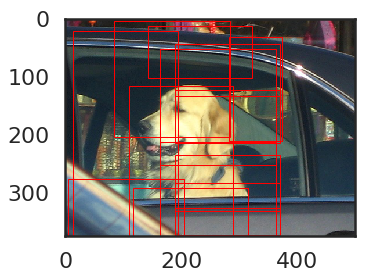

In [160]:
plot_f(results[0], Test_dataset[0])

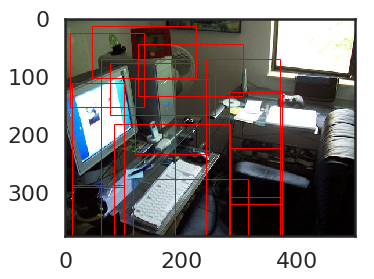

In [161]:
plot_f(results[1], Test_dataset[1])

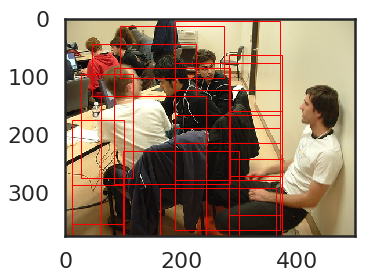

In [162]:
plot_f(results[2], Test_dataset[2])

# Predicted boundary boxes

In [85]:
final_res = []
for res in results:
    temp = []
    for r in res:
        temp.append(list(r))
    
    final_res.append(temp)

# AP and mAP scores 

In [98]:
from __future__ import absolute_import, division, print_function

from copy import deepcopy
import json
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context('poster')

In [99]:
COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

In [100]:
def calc_iou_individual(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box
    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]
    Returns:
        float: value of the IoU for the two boxes.
    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou

In [101]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """

    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = []
    pred_idx_thr = []
    ious = []
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)

    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)

    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

In [102]:
def calc_precision_recall(img_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)

In [103]:
def get_model_scores_map(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

In [104]:
def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    """Calculates average precision at given IoU threshold.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: avg precision as well as summary info about the PR curve
        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)

        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [105]:
def plot_pr_curve(
    precisions, recalls, category='Person', label=None, color=None, ax=None):
    """Simple plotting helper function"""

    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.gca()

    if color is None:
        color = COLORS[0]
    ax.scatter(recalls, precisions, label=label, s=20, color=color)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall curve for {}'.format(category))
    ax.set_xlim([0.0,1.3])
    ax.set_ylim([0.0,1.2])
    return ax


In [145]:
iou_thr = 0.5
start_time = time.time()
data = get_avg_precision_at_iou(ground_truth_boxes, final_res, iou_thr=iou_thr)
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))

start_time = time.time()
ax = None
avg_precs = []
iou_thrs = []
for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
    avg_precs.append(data['avg_prec'])
    iou_thrs.append(iou_thr)

    precisions = data['precisions']
    recalls = data['recalls']
    ax = plot_pr_curve(
        precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

# prettify for printing:
avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

In [ ]:
# %time test(resnet18)

In [ ]:
# #Two Layer Detection
# def test(resnet18):
#     # Write loops for testing the model on the test set
#     # Also print out the accuracy of the model

In [ ]:
# %time test(resnet18)